# Week 8 - Semantic & Influence Networks

This week, we explore the representation and analysis of semantic networks. A word or document network is an unsupervized representation of text akin to a clustering or an embedding, but semantic networks can also be defined using semantic or syntactic information derived from methods we have used earlier in the quarter. For example, we can define links between words as a function of their co-presence within a document, chapter, paragraph, sentence, noun phrase or continuous bag of words. We can also define links as a function of words that rely on one another within a directed dependency parse, or links between extracted Subjects, Verbs and Objects, or nouns and the adjectives that modify them (or verbs and the adverbs that modify *them*). Rendering words linked as a network or discrete topology allows us to take advantage of the wide range of metrics and models developed for network analysis. These include measurement of network centrality, density and modularity, "block modeling" structurally equivalent relationships, andsophisticated graphical renderings of networks or network partitions that allow us to visually interrogate their structure and complexity.

For this notebook we will use the following packages:

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip

#This will be doing most of the work
import networkx as nx

import nltk #For POS tagging
import sklearn #For generating some matrices
import pandas #For DataFrames
import numpy as np #For arrays
import matplotlib.pyplot as plt #For plotting
import seaborn #Makes the plots look nice
import scipy #Some stats

import pickle #if you want to save layouts
import os
import regex

%matplotlib inline

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that render some reasonable networks to meaningfully characterize the structure of words and documents (or subdocuments like chapters or paragraphs) from your corpus. What are useful filters and thresholds and what semantic structures do they reveal that given insight into the social world and social game inscribed in your corpus? Interrogate interesting subgraphs of your network and detail what they reveal about the semantic space involved.

<span style="color:blue"> I select near 100 chapters from the German philosophy corpus. 

In [2]:
import re


targetDir = '../german/kant'
platoText = []
platoFileName = []

for file in (file for file in os.scandir(targetDir) if file.is_file() and not file.name.startswith('.')):
    with open(file.path, encoding = 'latin-1') as f:
        platoText.append(f.read())
    platoFileName.append(file.name)

Kant = pandas.DataFrame({'text' : platoText, 'book' : platoFileName, 'author' : 'Kant'})


targetDir = '../german/hegel'
platoText = []
platoFileName = []

for file in (file for file in os.scandir(targetDir) if file.is_file() and not file.name.startswith('.')):
    with open(file.path, encoding = 'latin-1') as f:
        platoText.append(f.read())
    platoFileName.append(file.name)

Hegel = pandas.DataFrame({'text' : platoText, 'book' : platoFileName, 'author' : 'Hegel'})


targetDir = '../german/nietzsche'
platoText = []
platoFileName = []

for file in (file for file in os.scandir(targetDir) if file.is_file() and not file.name.startswith('.')):
    with open(file.path, encoding = 'latin-1') as f:
        platoText.append(f.read())
    platoFileName.append(file.name)

Nietzsche = pandas.DataFrame({'text' : platoText, 'book' : platoFileName, 'author' : 'Nietzsche'})

targetDir = '../german/schopenhauer'
platoText = []
platoFileName = []

for file in (file for file in os.scandir(targetDir) if file.is_file() and not file.name.startswith('.')):
    with open(file.path, encoding = 'latin-1') as f:
        platoText.append(f.read())
    platoFileName.append(file.name)

Schopenhauer = pandas.DataFrame({'text' : platoText, 'book' : platoFileName, 'author' : 'Schopenhauer'})


Kant = pandas.concat([Kant, Hegel, Nietzsche, Schopenhauer])
Kant.index = range(len(Kant))

# Remove some features vectors r"""\d +
remove = np.array([r'\[\d+\]', r'\(\d+\)', '\n', '\t', '\d+', r'\[\w+\]', r'\(\w+\)',
                   'â|ï»¿', 'Because', 'because', 'would', 'must', 'two', 'author',
                  'editor', 'say', 'two', 'done', 'may', 'without', 'might', 'could'])
       
for i in range(Kant.shape[0]):
    for j in range(len(remove)):
        Kant["text"].iloc[i] = regex.sub(remove[j], ' ', Kant["text"].iloc[i])

for i in range(Kant.shape[0]):
        Kant["text"].iloc[i] = regex.sub("[\s+\.\!\/_,$%^*=-\_][(+\"\']+", " ", Kant["text"].iloc[i])   

In [3]:
stop = ['one', 'even', 'still', 'doe', 'sinc', 'thus',
        'philosoph', 'One', 'Sinc', 'Thus', 'Since', 
        'Philosoph', 'ani', 'onli', 'everi', 'veri', 'anoth',
        'howev', 'Howev', 'well', 'also', 'becom', 'weather', 'much']
stop = stop + lucem_illud.stop_words_basic

In [4]:
Kant['tokenized_sents'] = Kant['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
Kant['normalized_sents'] = Kant['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s, stopwordLst = stop, stemmer = lucem_illud.stemmer_basic) for s in x])

In [5]:
def wordCooccurrence(sentences, makeMatrix = False):
    words = set()
    for sent in sentences:
        words |= set(sent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in sentences:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        return g

In [6]:
g = wordCooccurrence(Kant['normalized_sents'].sum())

In [7]:
len(g.nodes)

9533

In [8]:
len(g.edges)

687443

In [9]:
nx.to_numpy_matrix(g)[:5, :5]

matrix([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [10]:
def tokenize(text):
    tokenlist = nltk.word_tokenize(text)
    normalized = lucem_illud.normalizeTokens(tokenlist, stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic)
    return normalized

In [11]:
kantVectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)
kantVects_incidence = kantVectorizer.fit_transform(Kant['text'])

In [12]:
kantVects_incidence.shape

(82, 9551)

In [13]:
g_2mode = nx.Graph()

#define all the nodes
g_2mode.add_nodes_from((kantVectorizer.get_feature_names()[i] for i in range(kantVects_incidence.shape[1])), bipartite = 'word')
g_2mode.add_nodes_from(range(kantVects_incidence.shape[0]), bipartite = 'doc')

#add all the edges
g_2mode.add_edges_from(((d, kantVectorizer.get_feature_names()[w], {'weight' : kantVects_incidence[d, w]}) for d, w in zip(*kantVects_incidence.nonzero())))

In [14]:
print(nx.info(g_2mode))

Name: 
Type: Graph
Number of nodes: 9633
Number of edges: 62027
Average degree:  12.8780


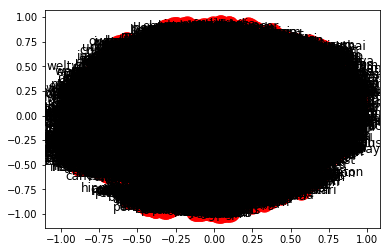

In [15]:
nx.draw_networkx(g_2mode)

In [16]:
def contractNetwork(g, targetType):
    g_mono = nx.Graph()
    g_mono.add_nodes_from(((n, d) for n, d in g_2mode.nodes(data = True) if d['bipartite'] == targetType))
    
    for n_outside in (n for n, d in g_2mode.nodes(data = True) if d['bipartite'] != targetType):
        neighbors = list((n for n in g.neighbors(n_outside) if g.nodes[n]['bipartite'] == targetType))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                try:
                    g_mono.edges[n1, n2]['weight'] += 1
                except KeyError:
                    g_mono.add_edge(n1, n2, weight = 1)
    return g_mono

In [17]:
gDoc = contractNetwork(g_2mode, 'doc')

In [18]:
print(nx.info(gDoc))

Name: 
Type: Graph
Number of nodes: 82
Number of edges: 3321
Average degree:  81.0000


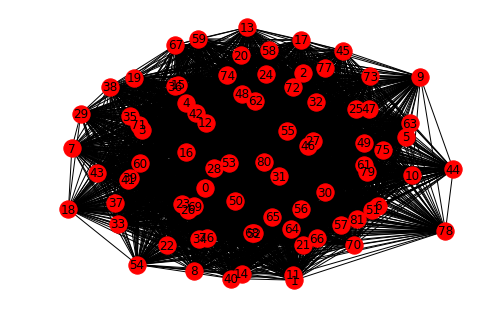

In [19]:
layout = nx.spring_layout(gDoc, k = 1/3, weight='weight', iterations= 50)
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()})

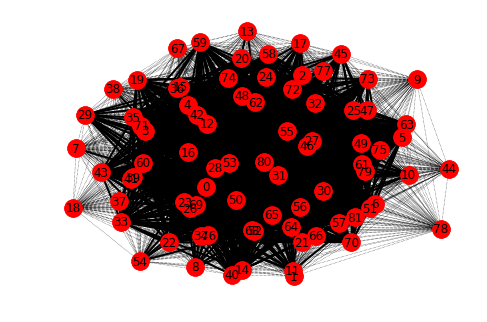

In [20]:
wMedian = np.median([d['weight'] for n1, n2, d in gDoc.edges(data = True)])
edgesHigh = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] > wMedian]
edgesLow = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] <= wMedian]
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}, edgelist = edgesLow, style='dotted', width=.5)
nx.draw(gDoc, pos = layout, nodelist=None, edgelist = edgesHigh, width=2)

In [29]:
print(len(Kant.iloc[80]['text']),"words:",
      "\n",Kant.iloc[80]['author'],"\n",
      Kant.iloc[80]['book'].strip().replace('  ', '\n'))

46231 words: 
 Schopenhauer 
 The World as Will and Idea Vol. 1.txt


In [28]:
print(len(Kant.iloc[78]['text']),"words:",
      "\n",Kant.iloc[78]['author'],"\n",
      Kant.iloc[78]['book'].strip().replace('  ', '\n'))

7524 words: 
 Schopenhauer 
 The indestructibility of our true being by death.txt


<span style="color:blue"> For documents, the documents with more words are more likely to be at the center.

In [26]:
wMean = np.mean([d['weight'] for n1, n2, d in gWord.edges(data = True)])
wMean

2.5046965409469104

In [27]:
g.remove_edges_from([(n1, n2) for n1, n2, d in g.edges(data = True) if d['weight'] <= 35])
g.remove_nodes_from(list(nx.isolates(g))) #since we are changing the graph list() evaluates the isolates first
giant = max(nx.connected_component_subgraphs(g), key=len) # keep just the giant connected component
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 168
Number of edges: 773
Average degree:   9.2024


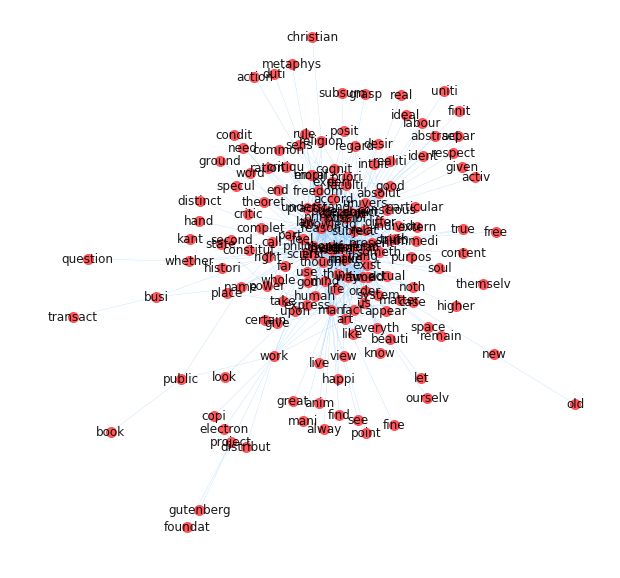

In [30]:
layout = nx.spring_layout(giant, weight='weight', iterations= 200)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue')

In [31]:
nx.clique.number_of_cliques(giant)['reason']

178

In [32]:
print(', '.join(max(nx.clique.find_cliques(giant), key = lambda x: len(x))))

natur, reason, object, concept, form, law, subject, principl, mere, pure


In [33]:
americanNeighbors = giant.neighbors('law')
g_american = giant.subgraph(americanNeighbors)
print(nx.info(g_american))

Name: 
Type: SubGraph
Number of nodes: 25
Number of edges: 155
Average degree:  12.4000


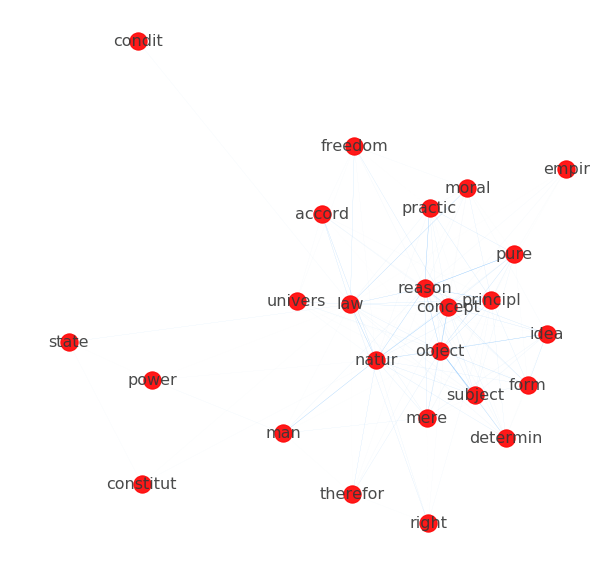

In [34]:
layout_amer = nx.spring_layout(g_american, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
maxWeight = max((d['weight'] for n1, n2, d in g_american.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_american.edges(data = True)))
nx.draw(g_american, ax = ax, pos = layout_amer, labels = {n:n for n in g_american.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_american.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma')) 

In [35]:
americanNeighbors = gWord.neighbors('pure')
americanNeighborsPlus1 = set(americanNeighbors)
for n in americanNeighbors:
    americanNeighborsPlus1 |= set(giant.neighbors(n))

In [36]:
g_american2 = giant.subgraph(americanNeighborsPlus1)
print(nx.info(g_american2))

Name: 
Type: SubGraph
Number of nodes: 165
Number of edges: 750
Average degree:   9.0909


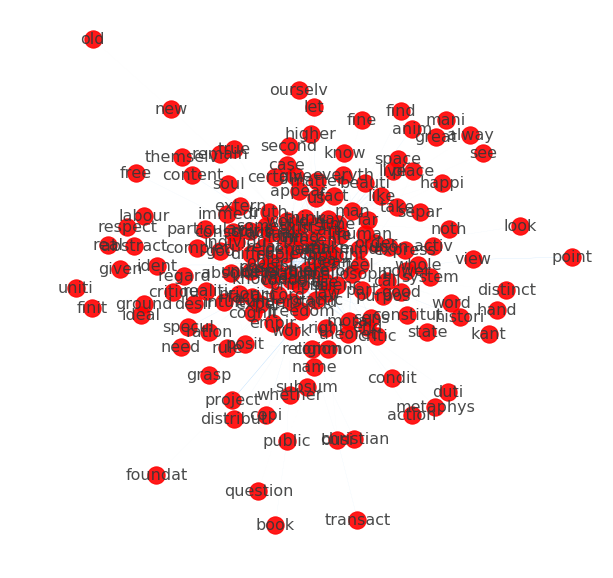

In [37]:
layout_amer = nx.spring_layout(g_american2, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
centralities_amer = nx.eigenvector_centrality(g_american2)
maxC = max(centralities_amer.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in g_american2.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_american2.edges(data = True)))
nx.draw(g_american2, ax = ax, pos = layout_amer, labels = {n:n for n in g_american2.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_american2.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma')) 

<span style="color:blue"> From the above graphs and results we can know that in German philosophy, the concepts are highly abstract, and these abstract concepts, such as reason, nature, law, principle and so on, are closely related to each other. However, many concepts that are more closely related to real word are marginalized.

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that calculate different kinds of centrality for distinct words or documents in a network composed from your corpus of interest. Which type of words tend to be most and least central? Can you identify how different centrality measures distinguish different kind of words in your corpus? What do these patterns suggest about the semantic content and structure of your documents? Finally, calculate global measure for your network(s) and discuss what they reveal.

In [38]:
dcentralities = nx.degree_centrality(giant)

In [55]:
dcentralities['human']

0.04191616766467066

In [56]:
max(dcentralities.items(), key = lambda x : x[1])

('natur', 0.46107784431137727)

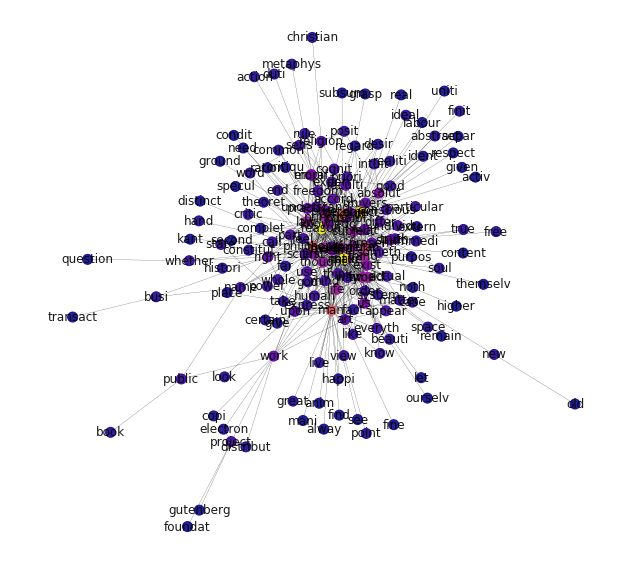

In [57]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities.items(), key = lambda x : x[1])[1]
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = [dcentralities[n] / maxC for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

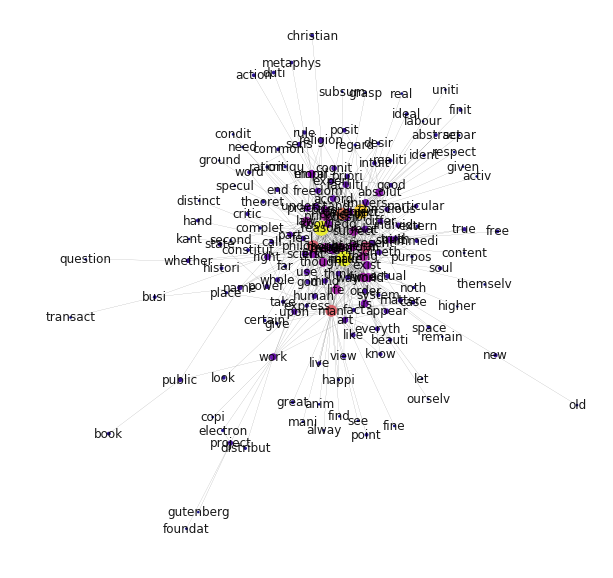

In [58]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gWord.edges(data = True)], 
        alpha = .9, 
        node_color = [dcentralities[n] / maxC for n in giant.nodes],
        node_size = [dcentralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

The distrubution of degree centrality is:

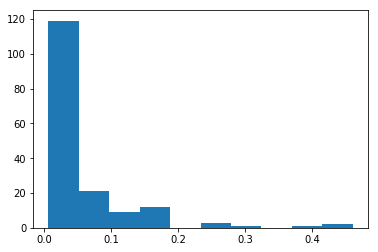

In [59]:
plt.hist(list(dcentralities.values()))
plt.show()

In [60]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('natur', 0.46107784431137727),
 ('reason', 0.45508982035928147),
 ('object', 0.4131736526946108),
 ('concept', 0.29940119760479045),
 ('man', 0.2694610778443114),
 ('philosophi', 0.2634730538922156),
 ('form', 0.23353293413173654),
 ('principl', 0.17365269461077845),
 ('idea', 0.16766467065868265),
 ('mere', 0.16766467065868265)]

In [61]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('old', 0.005988023952095809),
 ('transact', 0.005988023952095809),
 ('condit', 0.005988023952095809),
 ('let', 0.005988023952095809),
 ('copi', 0.005988023952095809),
 ('labour', 0.005988023952095809),
 ('kant', 0.005988023952095809),
 ('foundat', 0.005988023952095809),
 ('second', 0.005988023952095809),
 ('themselv', 0.005988023952095809)]

In [65]:
centralities = nx.betweenness.betweenness_centrality(giant)

In [66]:
centralities['human']

9.962862570899509e-06

In [67]:
max(centralities.items(), key = lambda x : x[1])

('reason', 0.21496613692224337)

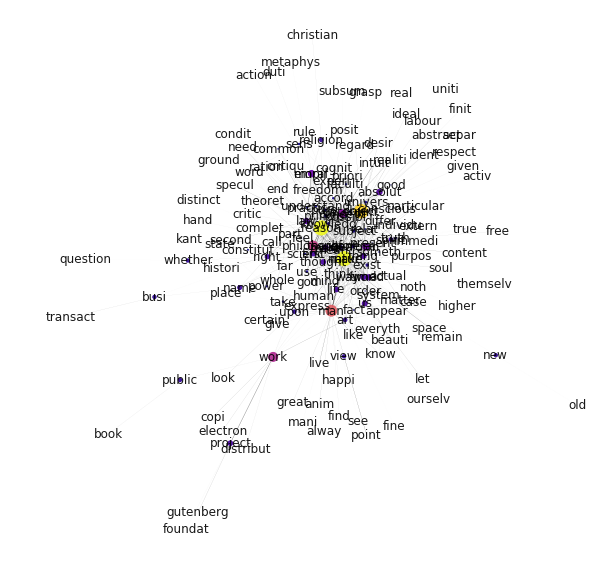

In [68]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

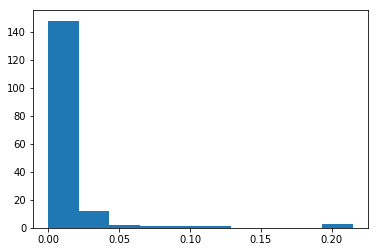

In [69]:
plt.hist(list(centralities.values()))
plt.show()

In [70]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('natur', 0.46107784431137727),
 ('reason', 0.45508982035928147),
 ('object', 0.4131736526946108),
 ('concept', 0.29940119760479045),
 ('man', 0.2694610778443114),
 ('philosophi', 0.2634730538922156),
 ('form', 0.23353293413173654),
 ('principl', 0.17365269461077845),
 ('idea', 0.16766467065868265),
 ('mere', 0.16766467065868265)]

In [71]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[50:60]

[('empir', 0.04790419161676647),
 ('truth', 0.04790419161676647),
 ('mind', 0.04790419161676647),
 ('think', 0.04790419161676647),
 ('religion', 0.04790419161676647),
 ('appear', 0.04790419161676647),
 ('cognit', 0.04790419161676647),
 ('conscious', 0.04191616766467066),
 ('feel', 0.04191616766467066),
 ('human', 0.04191616766467066)]

In [72]:
centralities = nx.closeness_centrality(giant)

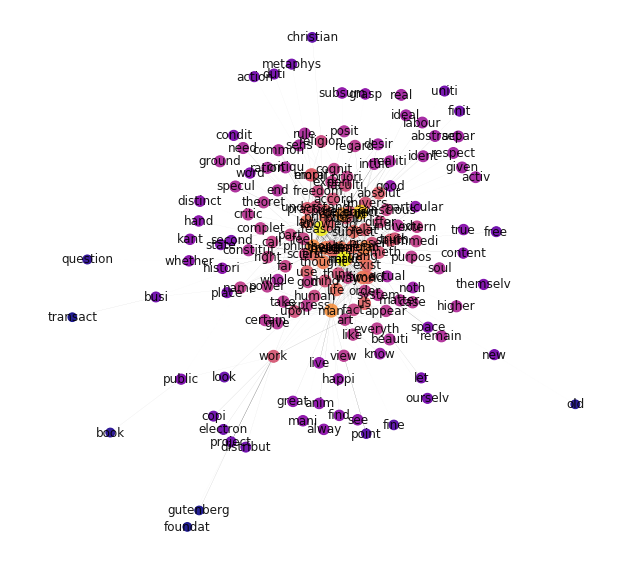

In [73]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

In [74]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('natur', 0.6278195488721805),
 ('reason', 0.6185185185185185),
 ('object', 0.5880281690140845),
 ('concept', 0.5318471337579618),
 ('man', 0.5284810126582279),
 ('philosophi', 0.5202492211838006),
 ('form', 0.5107033639143731),
 ('mere', 0.5030120481927711),
 ('thought', 0.5015015015015015),
 ('time', 0.49262536873156343)]

In [75]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('look', 0.30474452554744524),
 ('christian', 0.2992831541218638),
 ('fine', 0.29043478260869565),
 ('point', 0.2869415807560137),
 ('question', 0.2557427258805513),
 ('book', 0.24814264487369986),
 ('old', 0.24379562043795622),
 ('gutenberg', 0.23891273247496422),
 ('foundat', 0.23891273247496422),
 ('transact', 0.23823109843081314)]

In [76]:
centralities = nx.eigenvector_centrality(giant)

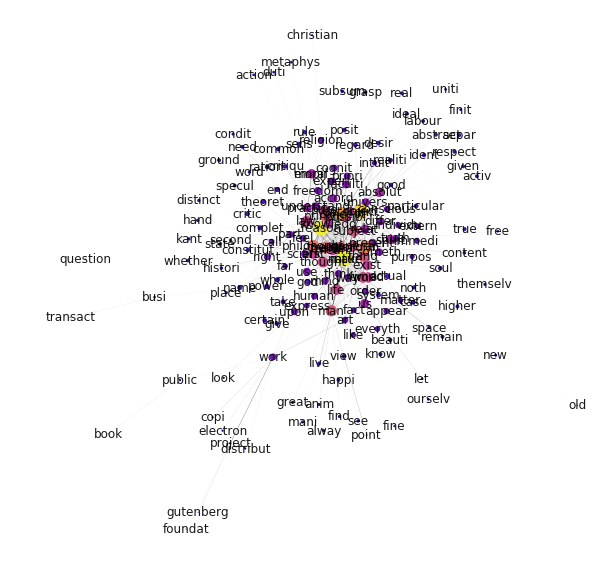

In [77]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

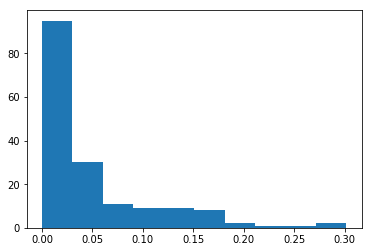

In [78]:
plt.hist(list(centralities.values()))
plt.show()

In [79]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('natur', 0.30174428683968285),
 ('reason', 0.2948191085657503),
 ('object', 0.2700819412043552),
 ('concept', 0.23858607888450412),
 ('form', 0.2056283207488865),
 ('philosophi', 0.1888645349728628),
 ('mere', 0.17725961454317465),
 ('idea', 0.1685629702283054),
 ('principl', 0.16381649559675138),
 ('man', 0.16102928302109226)]

In [80]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('copi', 0.002292414851110652),
 ('fine', 0.0019778553868685044),
 ('christian', 0.0018018436268517296),
 ('point', 0.0010059802353373339),
 ('question', 0.0004526551899976681),
 ('old', 0.0002637460827574541),
 ('book', 0.00015677790833155606),
 ('transact', 0.00014447908193994608),
 ('gutenberg', 0.00011356990769261963),
 ('foundat', 0.00011356990769261963)]

In [81]:
def filterWords(G, minWeight = 3, filter_ = "betweenness", rule = "number", value_of_rule = 200):
    """Function to filter network by degree centrality measures"""
    G = G.copy()
    try:
        G.remove_edges_from([(n1,n2) for n1, n2, d in G.edges(data = True) if d['weight'] < minWeight])
    except:
        print("weight might be missing from one or more edges")
        raise
    if filter_ =="betweenness":
        index = nx.betweenness_centrality(G) #betweeness centrality score
    elif filter_ == "closeness":
        index = nx.closeness_centrality(G) #closeness centrality score
    elif filter_ == "eigenvector":
        index = nx.eigenvector_centrality(G) #eigenvector centrality score
    elif filter_ == "degree":
        index = nx.degree_centrality(G) #degree centrality score
    else:
        raise ValueError("wrong filter paremeter, should be: betweenness/closeness/eigenvector")    
        
    if rule=='number':# if filter by limiting the total number of nodes 
        
        sorted_index = sorted(index.items(), key=lambda x:x[1], reverse=True)
        value_of_rule = np.min([value_of_rule, len(G.nodes)])
        
        nodes_remain = {}
        for word, centr in sorted_index[:value_of_rule]:
            nodes_remain[word] = centr
        G.remove_nodes_from([n for n in index if n not in nodes_remain])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='above':# if filter by limiting the min value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] >=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='below':# if filter by limiting the max value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] <=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G

In [82]:
giant_filtered30 = filterWords(giant, minWeight=3, filter_='betweenness', rule='number', value_of_rule=25)
print(nx.info(giant_filtered30))

Total number of nodes(after filtering) in the graph is 25
Name: 
Type: Graph
Number of nodes: 25
Number of edges: 161
Average degree:  12.8800


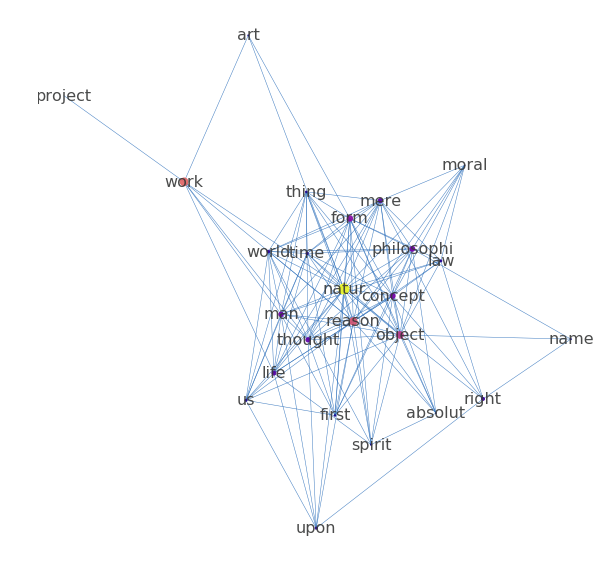

In [83]:
layout_giant_filtered30 = nx.spring_layout(giant_filtered30, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_giant30 = nx.betweenness_centrality(giant_filtered30)
maxC = max(centralities_giant30.items(), key = lambda x : x[1])[1]
nx.draw(giant_filtered30, ax = ax, pos = layout_giant_filtered30, labels = {n: n for n in giant_filtered30.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_giant30[n] / maxC for n in giant_filtered30.nodes],
        node_size = [centralities_giant30[n] / maxC * 100 for n in giant_filtered30.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

In [84]:
nx.density(giant)

0.05510407755916738

In [85]:
np.mean([v for w,v in nx.degree(giant)])

9.202380952380953

In [86]:
nx.diameter(giant)

6

<span style="color:blue"> The results here are not very different from those in the first part. But here we can find more specific networks. Nature and reason are at the center. They are closely related to the word "man". This might be because in German philosopy the nature of human being is regarded as the animal with reason. The morality is also an internal requirement of reason.

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that construct at least two different networks comprising different combinations of word types, linked by different syntactic structures, which illuminate your corpus and the dynamics you are interested to explore. Graph these networks or subnetworks within them. What are relationships that are meaningful? 

<span style="color:red">***Stretch***: Graph some word-centered "ego-networks" with words one link away, two links away, and three links away (we only did up to two links away above).

In [91]:
Kant['sentences'] = Kant['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
Kant.index = range(len(Kant) - 1, -1,-1) #Reindex to make things nice in the future
Kant[:3]

,author,book,text,tokenized_sents,normalized_sents,sentences
81,Kant,Anthropology from a Pragmatic Point of View.txt,PART ONE ANTHROPOLOGICAL DIDACTIC ON THE ART O...,"[[PART, ONE, ANTHROPOLOGICAL, DIDACTIC, ON, TH...","[[part, anthropolog, didact, art, know, interi...","[[PART, ONE, ANTHROPOLOGICAL, DIDACTIC, ON, TH..."
80,Kant,Kant_Injustice_Counterfeiting_Books.txt,Of The Injustice of Counterfeiting Books by I...,"[[Of, The, Injustice, of, Counterfeiting, Book...","[[injustic, counterfeit, book, immanuel, kant,...","[[Of, The, Injustice, of, Counterfeiting, Book..."
79,Kant,Kant_Judgement.txt,...,"[[THE, CRITIQUE, OF, JUDGEMENT, by, Immanuel, ...","[[critiqu, judgement, immanuel, kant, translat...","[[THE, CRITIQUE, OF, JUDGEMENT, by, Immanuel, ..."


Now we'll normalize the tokens through stemming:

In [92]:
Kant['normalized_sents'] = Kant['sentences'].apply(lambda x: [lucem_illud.normalizeTokens(s, stopwordLst = None, stemmer = lucem_illud.stemmer_basic) for s in x])

In [93]:
def posCooccurrence(sentences, *posType, makeMatrix = False):
    words = set()
    reducedSents = []
    #Only using the first kind of POS for each word
    wordsMap = {}
    for sent in sentences:
        s = [(w, t) for w, t in nltk.pos_tag(sent) if t in posType]
        for w, t in s:
            if w not in wordsMap:
                wordsMap[w] = t
        reducedSent = [w for w, t in s]
        words |= set(reducedSent)
        reducedSents.append(reducedSent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in reducedSents:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        for w in g.nodes:
            g.nodes[w]['bipartite'] = wordsMap[w]
        return g

In [257]:
gNN = posCooccurrence(Kant['normalized_sents'].sum(), 'NN')

In [258]:
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 7235
Number of edges: 243344
Average degree:  67.2686


In [410]:
gNN.remove_nodes_from([n for n in gNN.nodes if len(set(gNN.neighbors(n))) <= 2]) 
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 65
Number of edges: 369
Average degree:  11.3538


In [701]:
gNN.remove_edges_from([(n1, n2) for n1, n2, d in gNN.edges(data = True) if d['weight'] <= 27])
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 46
Number of edges: 179
Average degree:   7.7826


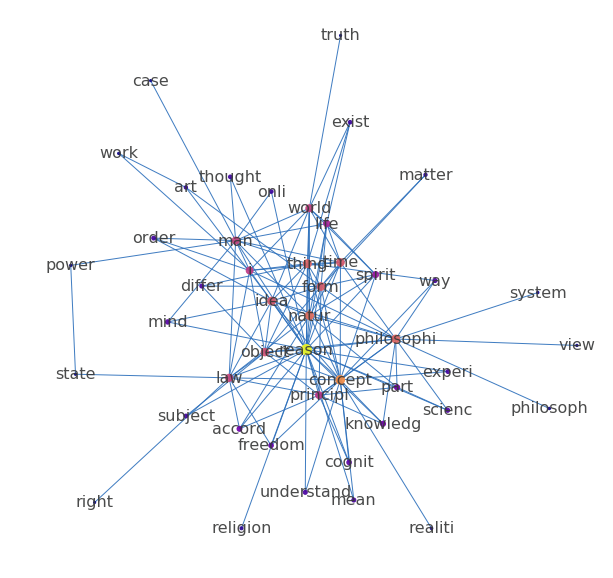

In [702]:
layout_nn = nx.spring_layout(gNN, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nn = nx.eigenvector_centrality(gNN)
maxC = max(centralities_nn.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNN.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNN.edges(data = True)))
nx.draw(gNN, ax = ax, pos = layout_nn, labels = {n: n for n in gNN.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nn[n] / maxC for n in gNN.nodes],
        node_size = [centralities_nn[n] / maxC * 100 for n in gNN.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

In [365]:
gJN = posCooccurrence(Kant['normalized_sents'].sum(), 'JJ', 'NN')

In [366]:
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 8442
Number of edges: 419442
Average degree:  99.3703


In [367]:
gJN.remove_edges_from([(n1,n2) for n1,n2,d in gJN.edges(data = True) if gJN.nodes[n1]['bipartite'] == gJN.nodes[n2]['bipartite']])

In [368]:
print(nx.info(gJN))

Name: 
Type: Graph
Number of nodes: 8442
Number of edges: 159665
Average degree:  37.8263


In [693]:
gJN.remove_nodes_from([n for n in gNV.nodes if len(set(gJN.neighbors(n))) <= 1])

In [690]:
gJN.remove_edges_from([(n1, n2) for n1, n2, d in gJN.edges(data = True) if d['weight'] <= 43])

In [694]:
print(nx.info(gJN))

Name: 
Type: Graph
Number of nodes: 42
Number of edges: 112
Average degree:   5.3333


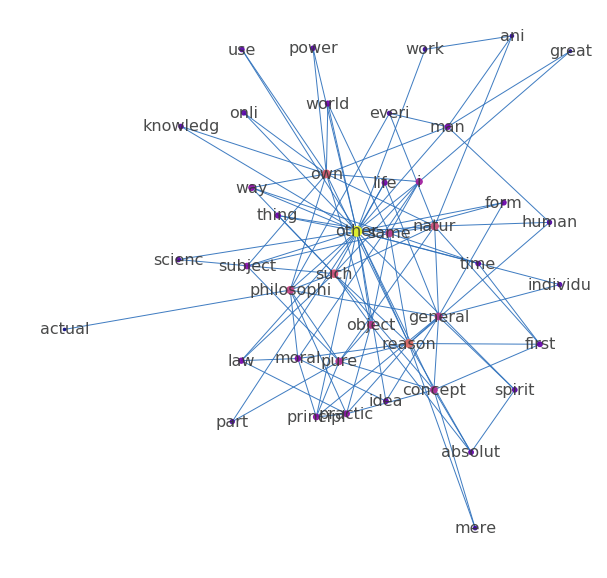

In [695]:
layout_nn = nx.spring_layout(gJN, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nv = nx.eigenvector_centrality(gJN)
maxC = max(centralities_nv.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gJN.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gJN.edges(data = True)))
nx.draw(gJN, ax = ax, pos = layout_nn, labels = {n: n for n in gNV.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nv[n] / maxC for n in gJN.nodes],
        node_size = [centralities_nv[n] / maxC * 100 for n in gJN.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       ) 

In [698]:
g_i = gJN.subgraph(['reason'] + list(gJN.neighbors('reason')))

In [699]:
print(nx.info(g_i))

Name: 
Type: SubGraph
Number of nodes: 13
Number of edges: 12
Average degree:   1.8462


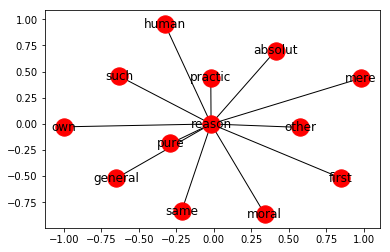

In [700]:
nx.draw_networkx(g_i)

In [418]:
storyNeighbors = gNV.neighbors('natur')
set(storyNeighbors)

{'absolut',
 'actual',
 'ani',
 'certain',
 'everi',
 'first',
 'general',
 'human',
 'mere',
 'moral',
 'other',
 'own',
 'practic',
 'pure',
 'real',
 'right',
 'same',
 'such',
 'veri',
 'whole'}

In [419]:
storyNeighbors = set(gJN.neighbors('natur'))
storyNeighborsPlus1 = set(storyNeighbors)
for n in storyNeighbors:
    storyNeighborsPlus1 |= set(gJN.neighbors(n))

In [420]:
gJN_story = gJN.subgraph(storyNeighborsPlus1)
print(nx.info(gJN_story))

Name: 
Type: SubGraph
Number of nodes: 60
Number of edges: 375
Average degree:  12.5000


In [421]:
sorted(nx.degree_centrality(gJN_story).items(), key = lambda x: x[1], reverse = True)[:10]

[('other', 0.6779661016949152),
 ('such', 0.6101694915254238),
 ('own', 0.6101694915254238),
 ('general', 0.5084745762711864),
 ('ani', 0.423728813559322),
 ('same', 0.3728813559322034),
 ('natur', 0.3389830508474576),
 ('pure', 0.3050847457627119),
 ('reason', 0.3050847457627119),
 ('first', 0.3050847457627119)]

In [422]:
sorted(nx.eigenvector_centrality(gJN_story).items(), key = lambda x: x[1], reverse = True)[:10]

[('other', 0.2594932891148704),
 ('such', 0.24549640162668523),
 ('own', 0.2453626911360588),
 ('general', 0.2119183192242725),
 ('ani', 0.20007729500318902),
 ('natur', 0.1849509777791282),
 ('same', 0.18316603814486845),
 ('reason', 0.1758441535306978),
 ('onli', 0.1634876934991242),
 ('principl', 0.1624187881289448)]

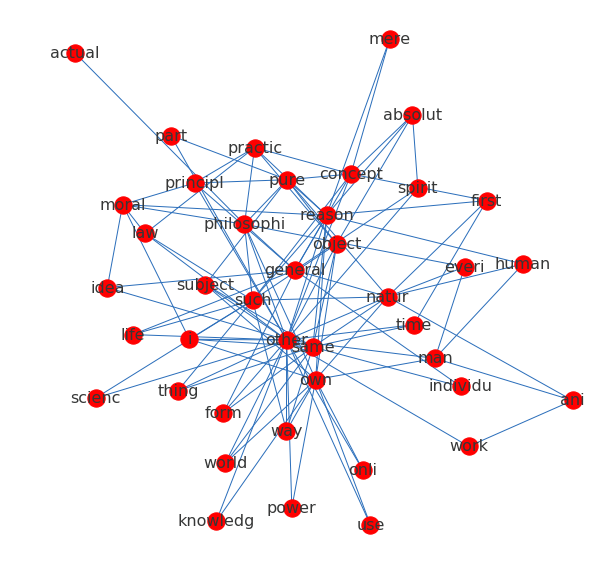

In [696]:
layout_story = nx.spring_layout(gJN_story, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(gJN_story, ax = ax, pos = layout_story, labels = {n: n for n in gJN_story.nodes()},
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
       ) 

In [577]:
gNN = posCooccurrence(Kant['normalized_sents'][:100].sum(), 'NN', 'NN')
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 7235
Number of edges: 243344
Average degree:  67.2686


In [659]:
gNN.remove_nodes_from([n for n in gNN.nodes if len(set(gNN.neighbors(n))) <= 1])

In [656]:
gNN.remove_edges_from([(n1, n2) for n1, n2, d in gNN.edges(data = True) if d['weight'] <= 36])

In [660]:
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 46
Number of edges: 179
Average degree:   7.7826


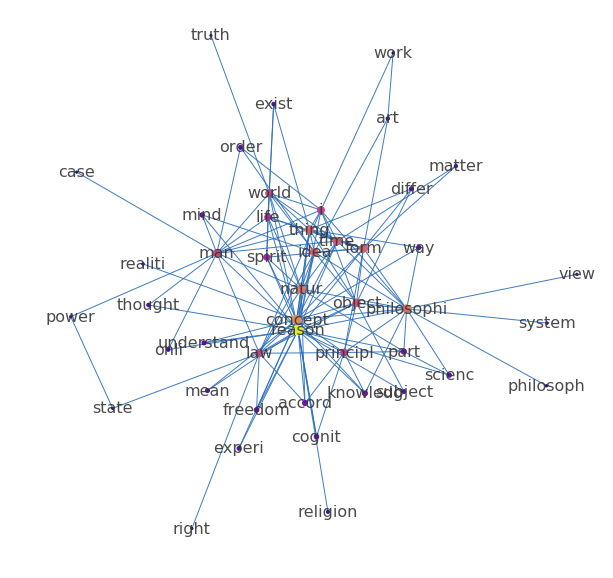

In [661]:
layout_nn = nx.spring_layout(gNN, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nv = nx.eigenvector_centrality(gNN)
maxC = max(centralities_nv.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNN.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNN.edges(data = True)))
nx.draw(gNN, ax = ax, pos = layout_nn, labels = {n: n for n in gNN.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nv[n] / maxC for n in gNN.nodes],
        node_size = [centralities_nv[n] / maxC * 100 for n in gNN.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       ) 

<span style="color:blue"> No matter how we change the combination of pos, most networks will have one center: either reason or nature. Besides, the concepts and the concepts combinations are all related to abstract concept such as pure reason, absolute spirit, etc. They reflect the abstract characteristics of German Philosophy.

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">Construct cells immediately below this that either (1) take data from a transcribed conversation, online chat forum, comment chain or some other *timed* interaction and calculate Bayesian influence; or (2) build a simulation similar in spirit to the "Presidents" example above, ideally infusing it with interesting "stylized facts". What does that estimation and its output reveal about the relative influence of each actor on others? What does it reveal about the social game being played?

<span style="color:blue"> I download the U.S. Supreme Court Oral Arguments corpus. But I only use a subsample for analysis.

In [790]:
col_names=['case','utterance_id','after_previous','name','justice','vote','presentation','utterance']
conver = pandas.read_csv('../supreme.txt',sep='\++\$\++',header = None,names = col_names)

F:\python\lib\site-packages\ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [791]:
conver = conver.drop(['case','utterance_id','after_previous','justice','vote','presentation'], axis=1)

In [792]:
conver = conver[:200]

In [794]:
for index,row in conver.iterrows():
    conver.set_value(index,'start',np.random.random())
    conver.set_value(index,'end',1+np.random.random())

In [795]:
conver['tokens'] = conver['utterance'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])

In [796]:
output_fname_conversation = 'USsupreme.xml'
language = 'eng' 
lucem_illud.make_TalkbankXML(conver, output_fname_conversation, language = language )

New File saved to .\data\USsupreme\USsupreme.xml


F:\python\lib\site-packages\lucem_illud\bayesian.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['start'] = df['start'].apply(pd.to_numeric)
F:\python\lib\site-packages\lucem_illud\bayesian.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['end'] = df['end'].apply(pd.to_numeric)


0

In [797]:
Vocab_size = 50
sampling_time = 1500
lucem_illud.bec_run(output_fname_conversation, Vocab_size, language, sampling_time)

In [844]:
df_influence_supreme = pandas.read_csv('C:/Users/hankanyao/Documents/content-analysis-2018/8-Semantic-Networks/data/Results/SAMPLE-influence.txt',delim_whitespace=True)

In [845]:
df_participants_supreme = pandas.read_csv('C:/Users/hankanyao/Documents/content-analysis-2018/8-Semantic-Networks/data/Results/cast.txt', delim_whitespace=True)
person_id = pandas.Series(participants_supreme['agent.num'].values-1,index=participants_supreme['agent.name']).to_dict()

In [846]:
df_meta_info = pandas.read_table('C:/Users/hankanyao/Documents/content-analysis-2018/8-Semantic-Networks/data/Results/meta-info.txt',header=None)
df_log_prob = pandas.read_csv("C:/Users/hankanyao/Documents/content-analysis-2018/8-Semantic-Networks/data/Results/SAMPLE-log_prior_and_log_likelihood.txt",delim_whitespace=True) #log_prob samples

In [849]:
def getDensity(df):
    data = df#_log_prob['log.prior']
    density = scipy.stats.gaussian_kde(data)
    width = np.max(data) - np.min(data)
    xs = np.linspace(np.min(data)-width/5, np.max(data)+width/5,600)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    return xs, density(xs)

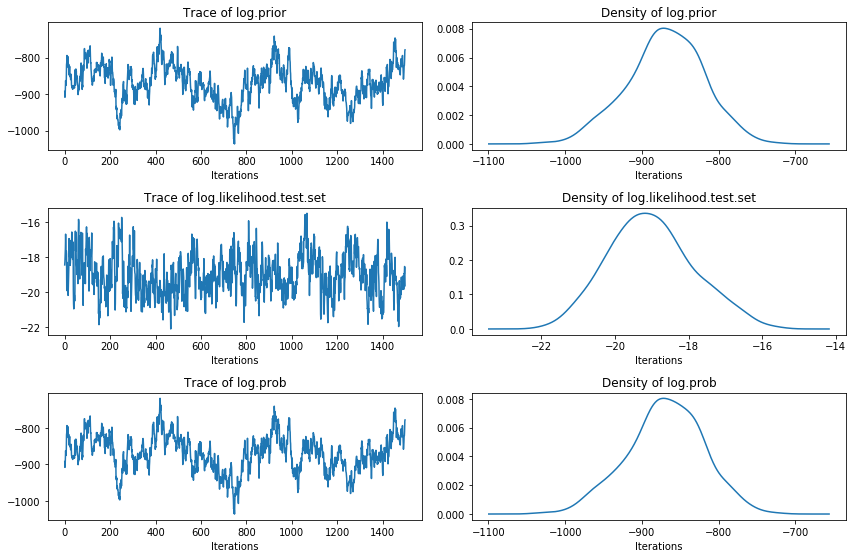

In [855]:
fig = plt.figure(figsize=[12,10])

plt.subplot(4,2,1)
plt.plot(df_log_prob['log.prior'])
plt.xlabel('Iterations')
plt.title('Trace of log.prior')

plt.subplot(4,2,2)
x,y = getDensity(df_log_prob['log.prior'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.prior')


plt.subplot(4,2,3)
plt.plot(df_log_prob['log.likelihood.test.set'])
plt.title('Trace of log.likelihood.test.set')
plt.xlabel('Iterations')
plt.tight_layout()

plt.subplot(4,2,4)
x,y = getDensity(df_log_prob['log.likelihood.test.set'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.likelihood.test.set')

plt.subplot(4,2,5)
plt.plot(df_log_prob['log.prior']+df_log_prob['log.likelihood'])
plt.title('Trace of log.prob')
plt.xlabel('Iterations')

plt.subplot(4,2,6)
x,y = getDensity(df_log_prob['log.prior']+df_log_prob['log.likelihood'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.prob')

plt.tight_layout()

plt.show()

In [822]:
A = int(np.sqrt(len(influence_supreme.columns))) #number of participants
id_person = {}
for p in person_id:
    id_person[person_id[p]]=p

In [823]:
stacked = influence_supreme.mean(axis=0)
mean_supreme = getmatrix(stacked,A)

stacked = influence_supreme.std(axis=0)
std_supreme = getmatrix(stacked,A)

MEAN of influence matrix (row=from, col=to)


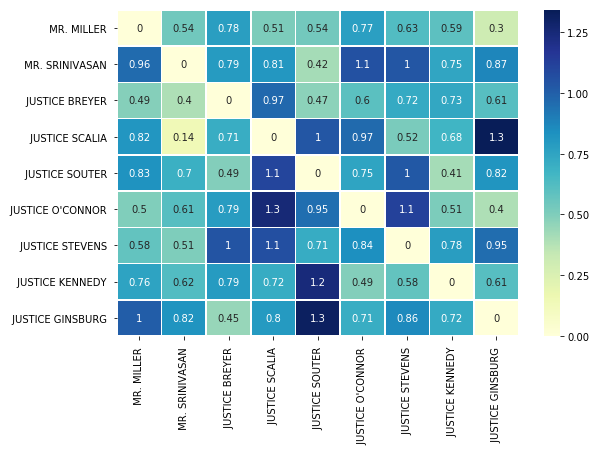

SD of influence matrix (row=from, col=to)


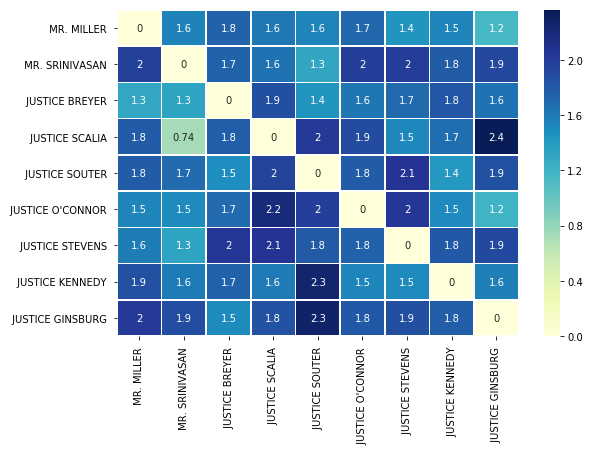

In [824]:
f, ax = plt.subplots(figsize=(9, 6))
seaborn.heatmap(mean_supreme, annot=True,  linewidths=.5, ax=ax,cmap="YlGnBu")
print('MEAN of influence matrix (row=from, col=to)')
plt.show()


f, ax = plt.subplots(figsize=(9, 6))
seaborn.heatmap(std_supreme, annot=True,  linewidths=.5, ax=ax,cmap="YlGnBu")
print('SD of influence matrix (row=from, col=to)')
plt.show()

In [825]:
sender_std = {} #sd of total influence sent
reciever_std = {} #sd of total influence recieved
for i in range(A):
    reciever_std[id_person[i]] = influence_supreme[influence_supreme.columns[i::A]].sum(axis=1).std()
    sender_std[id_person[i]] = influence_supreme[influence_supreme.columns[i*A:(i+1)*A:]].sum(axis=1).std()

sent_supreme = mean_supreme.sum(axis=1) #mean of total influence sent
recieved_supreme = mean_supreme.sum(axis=0)

		Total linguistic influence sent/received 


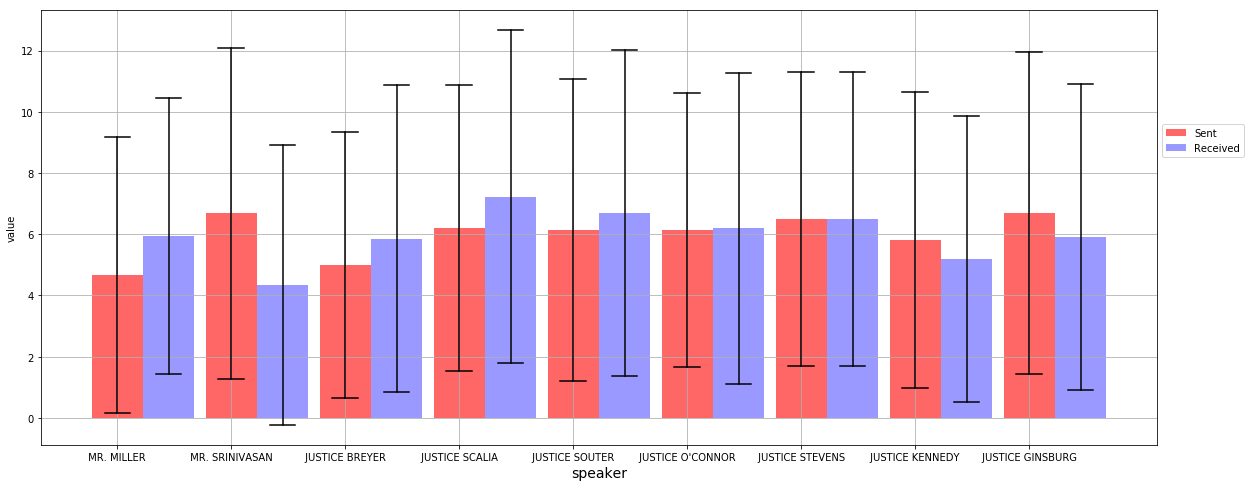

In [831]:
print ("\t\tTotal linguistic influence sent/received ")
ax.fig = plt.figure(figsize=[20,8])

plt.grid()
wd=0.45
ii=0
for p in sender_std:
    plt.bar(person_id[p],sent_supreme.loc[p],width=wd,color='red',alpha=0.6,label = "Sent" if ii == 0 else "")
    plt.plot([person_id[p]-wd/4,person_id[p]+wd/4],[sent_supreme.loc[p]+sender_std[p],sent_supreme.loc[p]+sender_std[p]],color='k')
    plt.plot([person_id[p]-wd/4,person_id[p]+wd/4],[sent_supreme.loc[p]-sender_std[p],sent_supreme.loc[p]-sender_std[p]],color='k')
    plt.plot([person_id[p],person_id[p]],[sent_supreme.loc[p]-sender_std[p],sent_supreme.loc[p]+sender_std[p]],color='k')
    ii+=1
ii=0
for p in reciever_std:
    plt.bar(person_id[p]+wd,recieved_supreme.loc[p],width=wd,color='blue',alpha=0.4,label = "Received" if ii == 0 else "")
    plt.plot([person_id[p]+wd-wd/4,person_id[p]+wd+wd/4],[recieved_supreme.loc[p]+reciever_std[p],recieved_supreme.loc[p]+reciever_std[p]],color='k')
    plt.plot([person_id[p]+wd-wd/4,person_id[p]+wd+wd/4],[recieved_supreme.loc[p]-reciever_std[p],recieved_supreme.loc[p]-reciever_std[p]],color='k')
    plt.plot([person_id[p]+wd,person_id[p]+wd],[recieved_supreme.loc[p]-reciever_std[p],recieved_supreme.loc[p]+reciever_std[p]],color='k')
    ii+=1
plt.legend(loc='center left', bbox_to_anchor=(1, 0.7))
plt.xticks([i for i in range(A)],list(zip(*sorted(id_person.items())))[1])
plt.ylabel('value')
plt.xlabel('speaker',fontsize=14)
plt.show()

In [833]:
def drawNetwork(df,title):
    fig = plt.figure(figsize=[8,8])
    G = nx.DiGraph()
    for from_ in df.index:
        for to_ in df.columns:
            G.add_edge(from_,to_,weight = df.loc[from_][to_])
            
    pos = nx.spring_layout(G,k=0.55,iterations=20)
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    weights = np.array(weights)
    #weights = weights*weights
    weights = 6*weights/np.max(weights)
    print(title)
    
    edge_colors=20*(weights/np.max(weights))
    edge_colors = edge_colors.astype(int)
#     nx.draw_networkx_nodes(G,pos,node_size=1200,alpha=0.7,node_color='#99cef7')
#     nx.draw_networkx_edges(G,pos,edge_color=edge_colors)
#     nx.draw_networkx_labels(G,pos,font_weight='bold')
    nx.draw(G,pos,with_labels=True, font_weight='bold',width=weights,\
            edge_color=255-edge_colors,node_color='#99cef7',node_size=1200,\
            alpha=0.75,arrows=True,arrowsize=20)
    return edge_colors

In [834]:
stacked = influence_supreme.quantile(0.25)
df_q25 = getmatrix(stacked,A)

stacked = influence_supreme.quantile(0.5)
df_q50 = getmatrix(stacked,A)

stacked = influence_supreme.quantile(0.75)
df_q75 = getmatrix(stacked,A)

Mean Influence Network


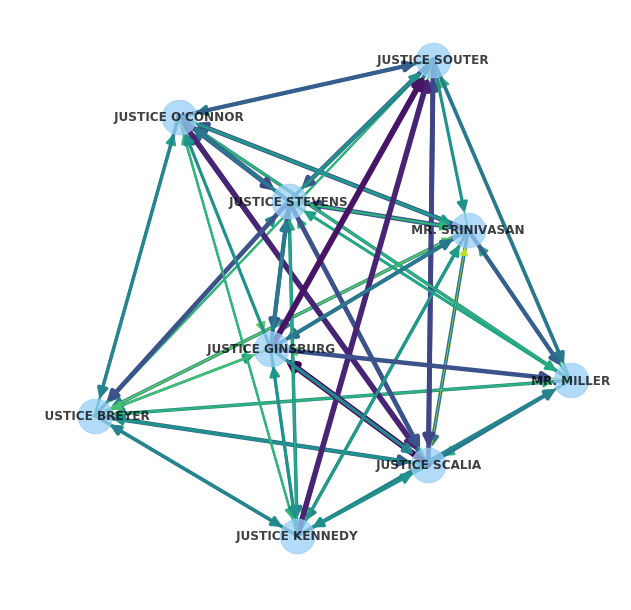

In [835]:
G_mean = drawNetwork(df_mean_supreme,'Mean Influence Network')

25 Quantile Influence Network


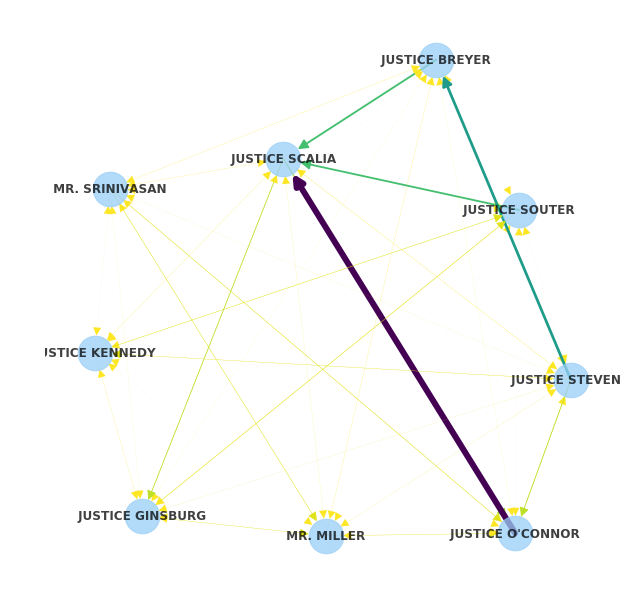

In [836]:
G_q25 = drawNetwork(df_q25,'25 Quantile Influence Network')

75 Quantile Influence Network


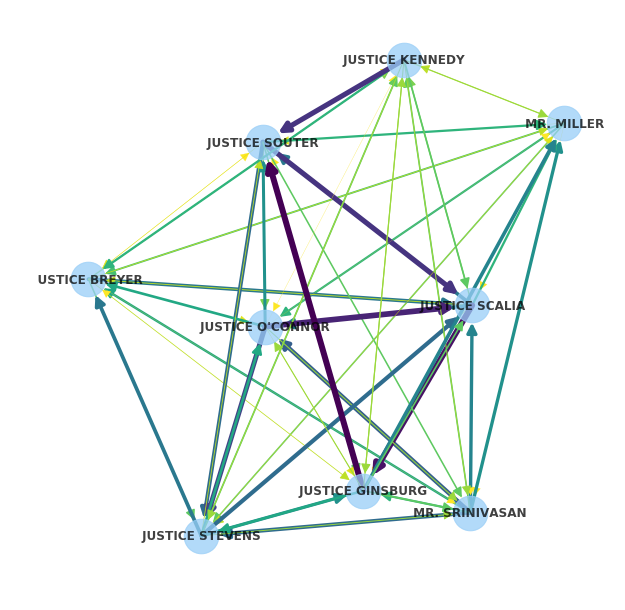

In [837]:
G_q75 = drawNetwork(df_q75,'75 Quantile Influence Network')

<span style="color:blue"> It is interesting that Justice O'Conner have a big influence on Justice Scalia in the 25 Quantile Influence Network. Besides, Justice Scalia is also moderately influenced by other two justices. However, other Justices and people do not show a very close networks. However, in the mean influence network, most people are strongly interrelated with each other. I think this might be because people generally influence each other, but in some specific cases or periods some people will be strongly influenced by some other people in single direction.